In [1]:
import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
fc = []
sex = []
race = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)-(.*)', subtask)
#     m = re.search('([^-]+)', subtask)
    sub = m.group(1)
    task = m.group(2)
    a = demo['age_at_cnb'][sub]
    age.append(a)
    s = demo['Sex'][sub] == 'M'
    r = demo['Race'][sub] == 'AA'
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age)
fc = np.stack(fc)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print([a.shape for a in [thetas, jitter, age, sex, race, fc]])
print(np.mean(age))

[(3849, 5, 264), (3849, 5, 264), (3849,), (3849,), (3849,), (3849, 34716)]
14.398285268901013


In [161]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
sex = []
race = []
sz = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
#     m = re.search('([^-]+)-(.*)', subtask)
    m = re.search('([^-]+)', subtask)
    sub = m.group(1)
#     task = m.group(2)
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] == 'SZP'
    if demo['DXGROUP_2'][sub] not in ['SZP', 'NC']:
        continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, sex, race, sz, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(441, 5, 264), (441, 5, 264), (441,), (441,), (441,), (441,), (441, 34716)]
0.4580498866213152
0.6439909297052154
0.5487528344671202
36.54875283446712


In [162]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
ps = tops(thetas, jitter)
aps = np.mean(ps, axis=1)
res = fc - aps

print(ps.shape)
print(aps.shape)
print(res.shape)

(441, 5, 34716)
(441, 34716)
(441, 34716)


In [163]:
from sklearn.decomposition import PCA, FactorAnalysis

# pca = PCA(n_components=1).fit(fc)
# fc_comp = pca.transform(fc)
# fc_low = pca.inverse_transform(fc_comp)

fa = FactorAnalysis(n_components=10).fit(fc)
fa_low = fa.transform(fc)@fa.components_
fa_res = fc-fa_low

print(fa_res.shape)

(441, 34716)


In [181]:
import torch
import torch.nn.functional as F

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def tonp(x):
    return x.detach().cpu().numpy()

sel = np.arange(fc.shape[0]) 
# sel = (sex == 1)*(race == 0)
# sel = (age < 12)*(race == 1)

fct = fromnp(fc[sel])
# dfc = torch.cdist(fct, fct)
fct = F.normalize(fct)
dfc = fct@fct.T
dfc = tonp(dfc)
print(dfc.shape)

idcs = np.argsort(dfc)
print(idcs[:100,-2])

(441, 441)
[339 351  80 393  80 383  80 431  80  80  62 107 312  80 440  80 312  62
  62 396 341  62 338 339  80  80 363  75  80  62 339 107  62 264  80  80
  49 331 225  62  62 404  62  38  24 431 341 338 341  62  80 440  80 396
 110  80  80  80  77 379 266  62  80 170 306 341  28 440  80  80 384 312
 396  77  24   8 363  62 331  80 431 349 110 396  62  80 339  80  76  80
 339  62  80  80  62  96  62   5 312 365]


In [182]:
import torch 
import torch.nn as nn

class Dists(nn.Module):
    def __init__(self, n):
        super(Dists, self).__init__()
        self.xy = nn.Parameter(torch.randn(n,2).float().cuda())
        
    def forward(self):
        return torch.cdist(self.xy, self.xy)

# tgt = 1e-1*np.ones(dfc.shape)
# for i in range(dfc.shape[0]):
#     tgt[i,idcs[i,-2000:]] = dfc[i, idcs[i,-2000:]]
    
# tgt = 1/fromnp(tgt)
tgt = 1/fromnp(dfc)
# tgt = torch.eye(dfc.shape[0]).float().cuda()
dists = Dists(dfc.shape[0])

nepochs = 1000
pperiod = 50

optim = torch.optim.Adam(dists.parameters(), lr=1e0, weight_decay=0)

for e in range(nepochs):
    optim.zero_grad()
    d = dists()
    loss = rmse(d, tgt)
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {float(loss)}')
        
print('Complete')

0 1.002767562866211
50 0.6130448579788208
100 0.6003545522689819
150 0.5990121364593506
200 0.6006123423576355
250 0.6030925512313843
300 0.5997536778450012
350 0.6041041016578674
400 0.6013402938842773
450 0.5991966724395752
500 0.6003602743148804
550 0.5998481512069702
600 0.6013060212135315
650 0.5993668437004089
700 0.6021568775177002
750 0.5993886590003967
800 0.6014479994773865
850 0.5999224781990051
900 0.5991966724395752
950 0.5999759435653687
999 0.6033398509025574
Complete


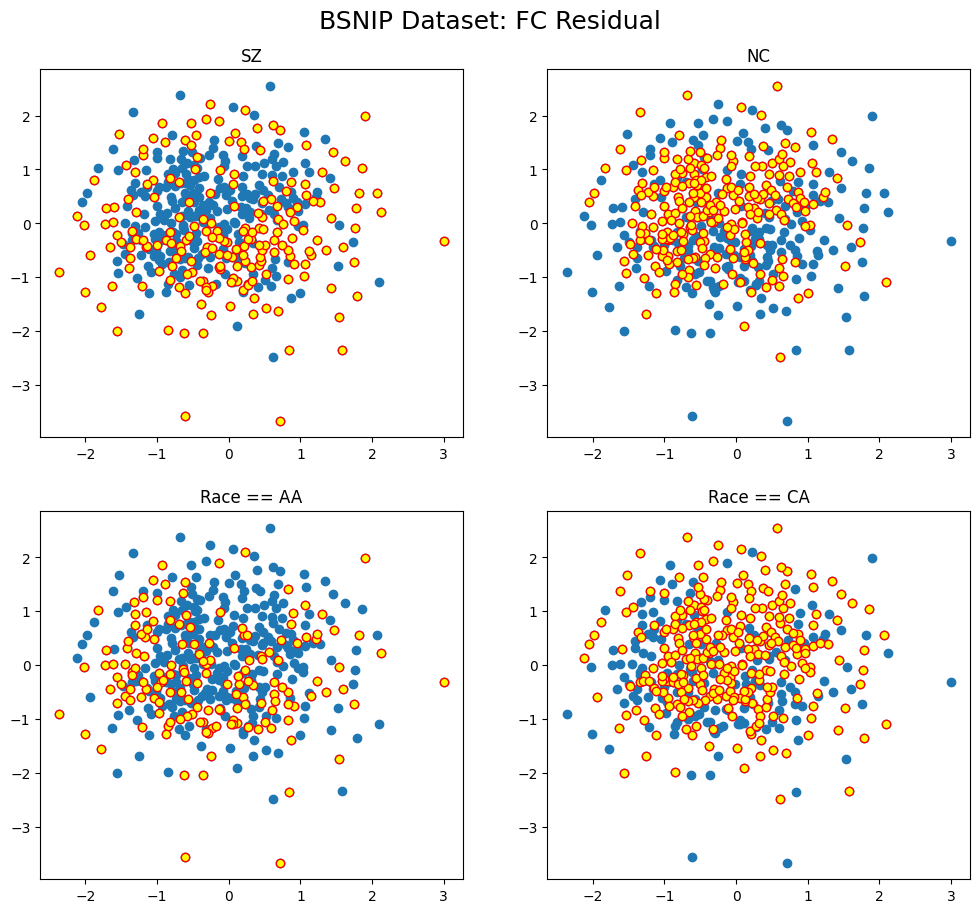

In [183]:
import matplotlib.pyplot as plt

dd = tonp(dists.xy)
# sel2 = age[sel] > 18 #(age[sel] > 18)
# sel2 = (sex[sel] == 1)*(race[sel] == 1)
# sel2 = race[sel] == 1
# sel2 = (sz[sel] == 1)#*(race == 0)*(sex == 1)#*(age < 35) #(age >= 12)*(age <= 18)
# sel = np.arange(dd.shape[0])

fig, ax = plt.subplots(2,2,figsize=(12,10))

fig.suptitle('BSNIP Dataset: FC Residual', fontsize=18)
fig.subplots_adjust(top=0.92)

sel2 = sz[sel] == 1 #(age[sel] < 10)

ax[0,0].scatter(dd[:,0], dd[:,1])
ax[0,0].scatter(dd[sel2,0], dd[sel2,1], color='yellow', edgecolor='red')
ax[0,0].set_title('SZ')

sel2 = sz[sel] == 0 #(age[sel] > 18)

ax[0,1].scatter(dd[:,0], dd[:,1])
ax[0,1].scatter(dd[sel2,0], dd[sel2,1], color='yellow', edgecolor='red')
ax[0,1].set_title('NC')

sel2 = race[sel] == 1 #(age[sel] > 16)*(race[sel] == 0)

ax[1,0].scatter(dd[:,0], dd[:,1])
ax[1,0].scatter(dd[sel2,0], dd[sel2,1], color='yellow', edgecolor='red')
ax[1,0].set_title('Race == AA')

sel2 = race[sel] == 0 #race[sel] == 0 #(age[sel] > 16)*(race[sel] == 1)

ax[1,1].scatter(dd[:,0], dd[:,1])
ax[1,1].scatter(dd[sel2,0], dd[sel2,1], color='yellow', edgecolor='red')
ax[1,1].set_title('Race == CA')

fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/UMAP_BSNIP_FC.pdf')
fig.show()

In [ ]:
import umap

reducer = umap.UMAP()
emb = reducer.fit_transform(aps)

print(emb.shape)

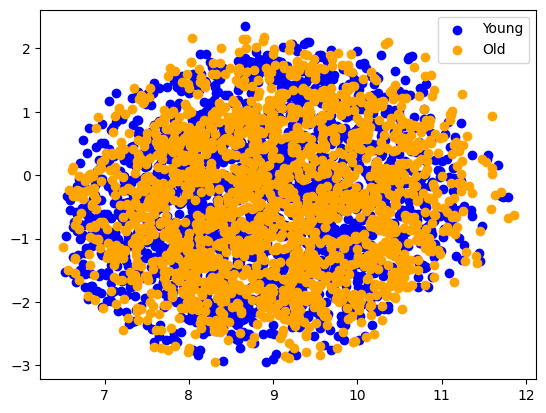

In [13]:
import matplotlib.pyplot as plt

color = iter(['blue', 'orange', 'green'])

# other = np.all([y != 0, y != 6], axis=0)
# plt.scatter(emb[other, 0], emb[other, 1], c=next(color), alpha=0.1, label='Other')

for c,lab in zip([race == 0, race == 1], ['Young', 'Old']):
    plt.scatter(emb[c,0], emb[c,1], c=next(color), label=lab)    
    
plt.legend()
plt.show()

In [7]:
emb[age < 12].shape

(914, 2)